# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [9]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [10]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [16]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[500:]

,text,category
09May2007Kennedy6.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy
09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy
09Nov2005Kennedy11.txt,FOR IMMEDIATE RELEASE The outrageous...,Kennedy
09Nov2006Kennedy6.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy
09Nov2006Kennedy7.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy
09Nov2007Kennedy10.txt,FOR IMMEDIATE RELEASE Mr Preside...,Kennedy
09Nov2007Kennedy9.txt,FOR IMMEDIATE RELEASE WASHINGTON ...,Kennedy
09Oct2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy
09Oct2006Kennedy5.txt,FOR IMMEDIATE RELEASE STATEMENT BY S...,Kennedy
09Oct2007Kennedy9.txt,FOR IMMEDIATE RELEASE WASHINGTON ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [17]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


In [184]:
lucem_illud.stop_words_basic

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [ ]:
['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 'should',
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 'couldn',
 'didn',
 'doesn',
 'hadn',
 'hasn',
 'haven',
 'isn',
 'ma',
 'mightn',
 'mustn',
 'needn',
 'shan',
 'shouldn',
 'wasn',
 'weren',
 'won',
 'wouldn']

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [18]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

In [179]:
#MYCODE
yelp_reviewW2V = gensim.models.word2vec.Word2Vec(yelp_review_df['normalized_sents'].sum())


array([-0.11862146,  0.33311498, -0.43220776, -0.28086147, -0.35177854,
       -0.2535357 , -0.11268201,  0.24313824, -0.27881145, -0.20560177,
       -0.2397739 ,  0.01237644, -0.07875748,  0.02990303,  0.2733548 ,
        0.08545996, -0.2075332 ,  0.5649065 , -0.3545065 ,  0.12021397,
       -0.35453206, -0.31070387,  0.4081539 , -0.06240889,  0.1011078 ,
       -0.06594517, -0.2497051 , -0.01192583,  0.16589086,  0.02452757,
       -0.13086164, -0.13676612,  0.06146326,  0.08647578, -0.2185428 ,
        0.04398369,  0.05937152, -0.2141547 , -0.22627912, -0.14584751,
       -0.13541825, -0.03599632, -0.04456887, -0.27386257,  0.11196995,
       -0.10333508,  0.1607745 ,  0.04449883, -0.06585941,  0.20671499,
        0.301435  ,  0.31031168, -0.19742273, -0.55925417,  0.21957219,
       -0.19591126, -0.15103573, -0.21502545, -0.11030754, -0.07192699,
       -0.1428107 , -0.08635134,  0.22082882, -0.2676207 , -0.18904941,
        0.14283589, -0.0141363 , -0.20915253,  0.03687188,  0.11

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [19]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([ 0.21463813, -2.4928463 , -1.3382112 , -0.29357967,  2.0879612 ,
       -0.9939671 , -0.7598374 , -4.248101  ,  0.6762936 ,  0.88042086,
        0.18618488, -1.1595953 , -0.30573738, -1.5931863 ,  1.2178746 ,
        1.6337193 , -3.1445951 ,  1.3695905 ,  2.7338495 , -1.8861676 ,
       -1.5638429 , -1.4282196 , -0.07621961, -0.8994843 ,  1.6432965 ,
        0.8211232 ,  2.4489074 , -0.9945894 , -0.5065598 ,  0.8359281 ,
       -1.203756  ,  0.45721918,  0.02443863, -0.40609115, -1.034926  ,
        2.6588278 ,  0.41259402,  1.4221814 ,  0.29908627,  0.33076504,
       -0.4949316 ,  2.0071507 , -0.73610616, -0.07186694, -0.83164024,
        3.5208094 ,  0.09666304, -1.3893684 ,  0.9527506 ,  0.29487088,
        1.3332533 , -1.1702693 , -0.5426937 , -0.61918175, -2.0740287 ,
        1.0176561 , -0.48862657,  0.19014102,  0.8597138 , -0.38488695,
        0.8181953 , -1.3129003 , -0.3793373 , -0.6382107 ,  0.036537  ,
       -0.4277667 , -1.344971  , -1.7617444 , -0.3062383 , -1.08

If you want the full matrix, `syn0` stores all the vectors:

In [22]:
senReleasesW2V.wv.syn0

array([[ 2.1344881e-01, -4.1819447e-01, -1.9157059e-01, ...,
         2.2685070e+00, -5.7846141e-01,  7.0319265e-01],
       [ 5.8106887e-01, -5.4966486e-01,  1.8359188e+00, ...,
         2.0568972e+00, -1.1634756e+00, -1.6431767e-01],
       [ 3.6444685e+00,  1.9614632e-01,  5.0251341e-01, ...,
         3.7233899e+00, -5.2450049e-01, -3.1448835e-01],
       ...,
       [-1.0690471e-02,  8.5790530e-03, -2.8077953e-02, ...,
         1.6923791e-02, -6.5001316e-02,  2.3269318e-03],
       [ 5.1551424e-02, -5.4274898e-02,  4.5313470e-02, ...,
        -8.4270686e-03,  4.9490955e-02,  1.3881481e-01],
       [ 4.0550131e-02,  6.8089287e-03, -2.4140751e-02, ...,
         2.9275462e-03, -8.1088513e-02,  7.8931515e-04]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [23]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [24]:
senReleasesW2V.most_similar('president')

[('administration', 0.7766852378845215),
 ('presidents', 0.7568691968917847),
 ('administrations', 0.6382181644439697),
 ('cheney', 0.5937356352806091),
 ('george', 0.5756371021270752),
 ('unchallenged', 0.5372523069381714),
 ('presidency', 0.5167504549026489),
 ('slash', 0.5121973156929016),
 ('veto', 0.510909378528595),
 ('democrats', 0.5106726288795471)]

In [25]:
senReleasesW2V.most_similar('war')

[('foment', 0.6553289294242859),
 ('unresisted', 0.6493677496910095),
 ('quagmire', 0.6483136415481567),
 ('disobedience', 0.6451053619384766),
 ('afghanistan', 0.6403235197067261),
 ('descending', 0.6291087865829468),
 ('wars', 0.6260169744491577),
 ('chaos', 0.6136266589164734),
 ('battle', 0.6076245307922363),
 ('strife', 0.5911901593208313)]

Or we can get this directly (calculated slightly differently):

In [26]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [27]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.5193637]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [28]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [29]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6456661224365234),
 ('vetoed', 0.6244863271713257),
 ('signed', 0.618177056312561),
 ('signing', 0.6126625537872314),
 ('veto', 0.6106950044631958),
 ('reverse', 0.6060127019882202),
 ('bushs', 0.6019455790519714),
 ('proposing', 0.6014896631240845),
 ('blocked', 0.596039354801178),
 ('signature', 0.5929346084594727)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [30]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.3045778,
 0.31956053,
 0.3492662,
 0.39131412,
 0.39257658,
 0.39285147,
 0.4085766,
 0.41813347,
 0.5054416,
 0.5095863,
 0.5136409,
 0.52183914,
 0.52511686,
 0.52787364,
 0.5519584,
 0.55683625,
 0.5632223,
 0.5646773,
 0.6228472,
 0.6311857]

In [31]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.31956053 0.6228472


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [32]:
senReleasesDF[sample_indices == i]

NameError: name 'sample_indices' is not defined

In [34]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))
print(len(sample_indices))
s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

3904
[0.95282114 0.9880504  0.94906157 0.96915871 0.98860079 0.97529066
 0.96891761 0.9932431  0.99676079 0.93959379]
[373. 378. 408. 387. 376. 409. 403. 387. 382. 401.]


In [35]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.6759147578281886 0.6802618512572749


We can also save the vectors for later use:

In [36]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [68]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]


We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [38]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.21344881, -0.41819447, -0.1915706 , ...,  2.268507  ,
        -0.5784614 ,  0.70319265],
       [ 0.5810689 , -0.54966486,  1.8359188 , ...,  2.0568972 ,
        -1.1634756 , -0.16431767],
       [ 3.6444685 ,  0.19614632,  0.5025134 , ...,  3.7233899 ,
        -0.5245005 , -0.31448835],
       ...,
       [ 2.9970026 ,  0.05243365,  1.2943149 , ...,  2.831482  ,
         0.05581347,  0.9685421 ],
       [ 1.0152698 , -0.5196835 ,  0.3119259 , ...,  0.44217932,
        -0.46727642, -0.94286615],
       [ 0.26481187,  0.11354718,  0.84900147, ..., -0.5389863 ,
        -0.6135969 ,  1.0370247 ]], dtype=float32)

(150, 100)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [39]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

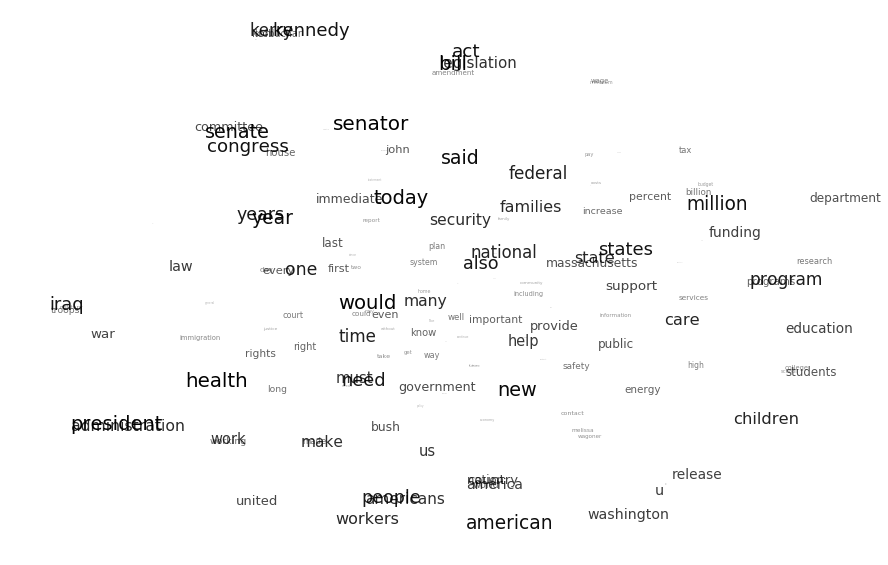

In [40]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [41]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [42]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [43]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [44]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([ 0.7039404 , -2.4237747 , -1.370748  ,  0.07407843,  2.264379  ,
       -0.73293245, -0.8072102 , -4.7497034 ,  0.95727897,  0.8400911 ],
      dtype=float32)

In [45]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([ 0.21463813, -2.4928463 , -1.3382112 , -0.29357967,  2.0879612 ,
       -0.9939671 , -0.7598374 , -4.248101  ,  0.6762936 ,  0.88042086],
      dtype=float32)

In [46]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([-0.48930228, -0.06907153,  0.03253686, -0.36765808, -0.17641783,
       -0.26103467,  0.04737282,  0.5016022 , -0.28098536,  0.04032975],
      dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [47]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

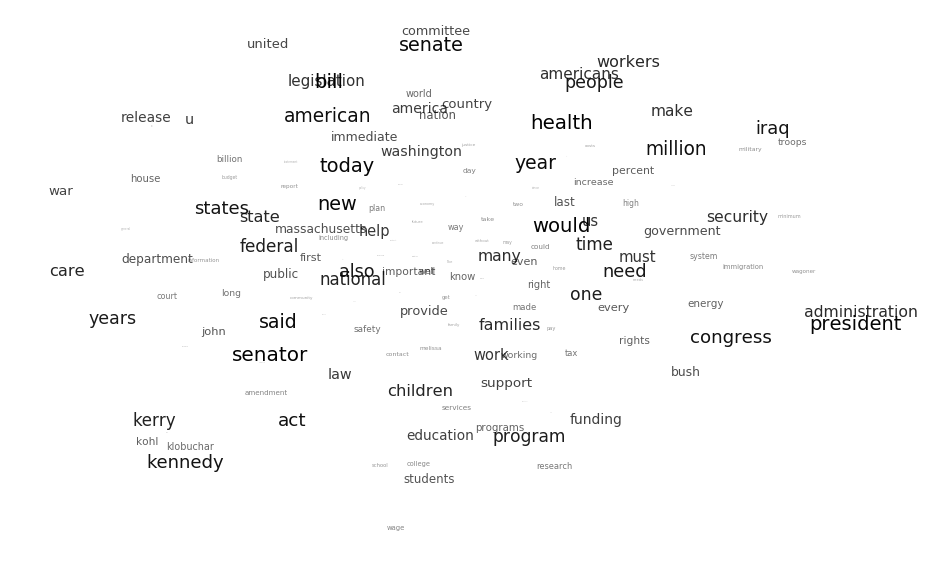

In [48]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [49]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1997659.0

Now we have the training loss and can optimize training to minimize it.

In [51]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

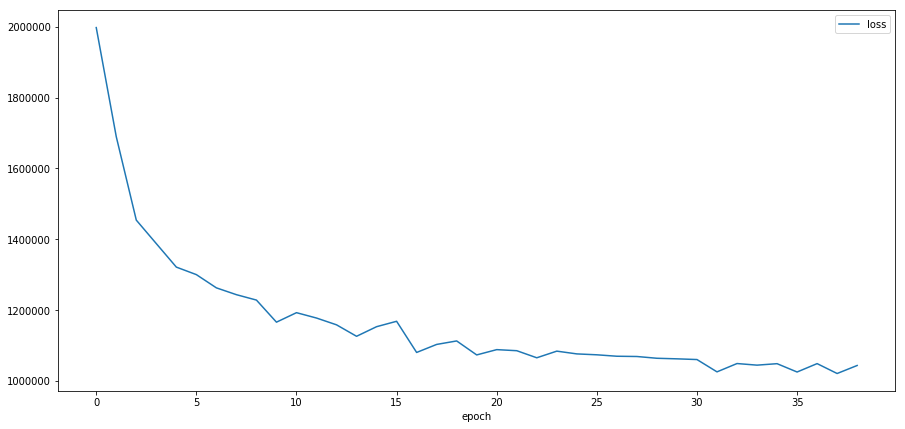

In [52]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [53]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))


KeyboardInterrupt



In [ ]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [257]:
#MYCODE
import pandas
yelp_review_df = pandas.read_csv('~/Desktop/reviews_test.csv', sep='\t')
yelp_review_df = yelp_review_df.dropna(axis=0, how='any')
yelp_review_df = yelp_review_df.drop(columns=['id','stars','date','useful','funny','cool','business_id','user_id','count','business_id.1'])

#Apply our functions, notice each row is a list of lists now
yelp_review_df['tokenized_sents'] = yelp_review_df['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
yelp_review_df['normalized_sents'] = yelp_review_df['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

yelp_review_df[:5]

,text,tokenized_sents,normalized_sents
0,"My favorite steakhouse in Las Vegas, somewhere...","[[My, favorite, steakhouse, in, Las, Vegas, ,,...","[[favorite, steakhouse, las, vegas, somewhere,..."
1,Was excited to go here since it was Emerille's...,"[[Was, excited, to, go, here, since, it, was, ...","[[excited, go, since, emerille, steakhouse], [..."
2,2012 Fall Restaurant Week Lunch #2. \n\nWhethe...,"[[2012, Fall, Restaurant, Week, Lunch, #, 2, ....","[[fall, restaurant, week, lunch], [visiting, d..."
3,My client took me here after the MAGIC Show an...,"[[My, client, took, me, here, after, the, MAGI...","[[client, took, magic, show, phenomenal], [ste..."
4,Man.. I'm drooling just thinking about the won...,"[[Man..], [I, 'm, drooling, just, thinking, ab...","[[], [drooling, thinking, wonderful, birthday,..."


In [258]:
print("A {} dimesional vector:".format(yelp_reviewW2V['food'].shape[0]))
yelp_reviewW2V['food']

A 100 dimesional vector:


array([-0.91921043,  0.19762449,  0.29196003, -0.18385409, -0.88740176,
        0.16285887, -0.01377422,  0.6034371 , -0.16297743, -0.54381734,
       -0.11517046,  0.19454272,  0.12345145,  0.10797631,  0.10069968,
       -0.00637935,  0.24259466,  0.91085804, -0.04876369, -0.0692218 ,
       -0.01158428, -0.33212045,  0.16828322,  0.03792886,  0.14265832,
       -0.07145777, -0.5563186 , -0.15335599,  0.17464714, -0.58363336,
       -0.5834192 , -0.03116621,  0.7911954 ,  0.49072328, -0.15974241,
       -0.60292363,  0.04504143, -0.14852326, -0.58651054, -0.3569277 ,
       -1.0669208 ,  0.11426397,  0.7895929 , -0.2789297 , -0.57736504,
       -0.6161326 ,  0.25583678,  0.00152427,  0.48105282, -0.0615464 ,
        0.2863452 ,  0.8840992 , -0.631543  , -0.81520516,  0.31174165,
       -0.13440175, -0.15868962, -0.4997187 , -0.01168316, -0.6479295 ,
       -0.1647868 , -0.7772418 ,  0.25738522, -0.44344458, -0.15399599,
       -0.05756202,  0.31716204, -0.5875488 ,  0.42612275,  0.39

In [261]:
yelp_reviewW2V.most_similar('food')

yelp_reviewW2V.most_similar(positive=['good', 'food'], negative = ['service'])

[('ok', 0.8488578200340271),
 ('nothing', 0.8435839414596558),
 ('absolutely', 0.8372264504432678),
 ('quality', 0.8346982002258301),
 ('decent', 0.8346021771430969),
 ('better', 0.8321236968040466),
 ('much', 0.8308576941490173),
 ('mexican', 0.8214797377586365),
 ('liked', 0.820330798625946),
 ('authentic', 0.8199489116668701)]

Food to good is as service to ok? Haha this is interesting. I guess a good quality of mean can compensate for the just-so-so service!

In [259]:
#MYCODE
estimates_C=[]
for x in range(20):
    yelp_review_W2VB = gensim.models.word2vec.Word2Vec(yelp_review_df['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimates_C.append(cos_difference(yelp_review_W2VB, 'good', 'food')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimates_C.sort()         
estimates_C

[0.43990928,
 0.4483897,
 0.4666776,
 0.4779605,
 0.48316297,
 0.4904956,
 0.504279,
 0.5044637,
 0.50479084,
 0.51267654,
 0.51576394,
 0.5192486,
 0.5201976,
 0.5250119,
 0.53436565,
 0.53745997,
 0.5432213,
 0.54480445,
 0.546463,
 0.5478148]

In [260]:

print("The 90% confidence interval for the cosine distance between good and food is:\n",estimates_C[1], estimates_C[-2])

The 90% confidence interval for the cosine distance between good and food is:
 0.4483897 0.546463


In [262]:
#MYCODE
targetWords_review = yelp_reviewW2V.wv.index2word[:numWords]
targetWords_review

['food',
 'good',
 'place',
 'great',
 'thai',
 'service',
 'like',
 'would',
 'time',
 'one',
 'go',
 'get',
 'really',
 'wait',
 'back',
 'ordered',
 'steak',
 'best',
 'restaurant',
 'us',
 'also',
 'got',
 'delicious',
 'well',
 'table',
 'salad',
 'could',
 'vegas',
 'little',
 'try',
 'nice',
 'came',
 'even',
 'order',
 'love',
 'amazing',
 'always',
 'menu',
 'chicken',
 'meal',
 'rice',
 'definitely',
 'curry',
 'tacos',
 'breakfast',
 'ever',
 'eat',
 'first',
 'much',
 'pretty',
 'people',
 'went',
 'better',
 'experience',
 'come',
 'dinner',
 'make',
 'made',
 'side',
 'small',
 'right',
 'pad',
 'staff',
 'never',
 'spicy',
 'noodles',
 'worth',
 'think',
 'way',
 'bit',
 'big',
 'two',
 'cooked',
 'awesome',
 'say',
 'dish',
 'sauce',
 'still',
 'next',
 'lunch',
 'sure',
 'delmonico',
 'everything',
 'fried',
 'friendly',
 'know',
 'night',
 'want',
 'flavor',
 'though',
 'long',
 'matt',
 'server',
 'excellent',
 'fresh',
 'recommend',
 'said',
 'times',
 'shrimp',
 't

Let's visualize the top words from the reviews. As we can see from the plot, the reviews that I selected seem to come from restaurants with good reputaions. Words like great, food and service are close to each other. And also definately go back, instead of never go back. 

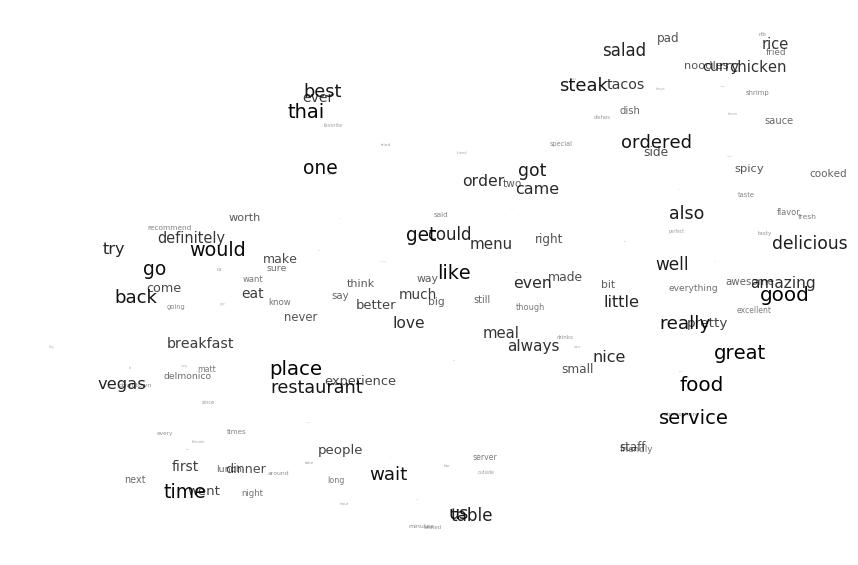

In [263]:
#MYCODE
wordsSubMatrix_review = []
for word in targetWords_review:
    wordsSubMatrix_review.append(yelp_reviewW2V[word])
wordsSubMatrix_review = np.array(wordsSubMatrix_review)
wordsSubMatrix_review
#MYCODE
pcaWords_review = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_review)
reducedPCA_data_review = pcaWords.transform(wordsSubMatrix_review)
#T-SNE is theoretically better, but you should experiment
tsneWords_review = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data_review)

#MYCODE
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_review[:, 0], tsneWords_review[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_review):
    ax.annotate(word, 
                (tsneWords_review[:, 0][i],tsneWords_review[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [74]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [76]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [132]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))
apsDF[:10]

,copyrightYear,doi,abstract,tokenized_words,normalized_words,TaggedAbstracts
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[A, summarizing, account, is, given, of, the, ...","[summarizing, account, given, research, barium...","([summarizing, account, given, research, bariu..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[New, tables, of, coulomb, functions, are, pre...","[new, tables, coulomb, functions, presented, a...","([new, tables, coulomb, functions, presented, ..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[Ionization, by, electron, impact, in, diatomi...","[ionization, electron, impact, diatomic, gases...","([ionization, electron, impact, diatomic, gase..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[It, is, shown, that, the, conductivity, in, t...","[shown, conductivity, ohmic, part, cuprous, ox...","([shown, conductivity, ohmic, part, cuprous, o..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[The, factorization, method, is, an, operation...","[factorization, method, operational, procedure...","([factorization, method, operational, procedur..."
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...,"[A, brief, account, is, given, of, Dyson, 's, ...","[brief, account, given, dyson, proof, finitene...","([brief, account, given, dyson, proof, finiten..."
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...,"[A, systematics, is, given, of, all, transitio...","[systematics, given, transitions, odd, nuclei,...","([systematics, given, transitions, odd, nuclei..."
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...,"[A, systematics, of, the, -transitions, of, ev...","[systematics, even, nuclei, given, interpretat...","([systematics, even, nuclei, given, interpreta..."
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...,"[The, available, experiments, on, the, absorpt...","[available, experiments, absorption, spectra, ...","([available, experiments, absorption, spectra,..."
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...,"[The, classical, theory, of, the, dynamics, of...","[classical, theory, dynamics, viscous, fluids,...","([classical, theory, dynamics, viscous, fluids..."


In [77]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [106]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [79]:
apsD2V.docvecs[1952]

array([ 1.1811744 ,  1.5147003 , -0.73831177,  1.5701269 , -0.9774414 ,
        0.0477    ,  1.161216  ,  0.35431048,  0.41138884,  2.242039  ,
       -0.91834915, -1.1019025 , -0.60383505,  0.73166007, -1.0051209 ,
       -0.3605346 ,  0.14477801,  0.59834605,  0.47805145, -2.007724  ,
       -1.9772297 , -0.6744852 ,  0.6405004 ,  1.5111965 , -0.2935183 ,
       -0.903807  ,  0.9401995 ,  1.0291687 , -0.01867682,  0.4405708 ,
        0.4895386 ,  0.95484716, -0.21926998,  0.80853677, -0.3797004 ,
        0.30740857, -1.2028925 , -0.53314376,  0.6070704 , -1.0599887 ,
       -0.5980537 , -0.2935382 ,  0.70740813,  0.32581466,  1.22979   ,
       -0.6651801 , -0.43381855, -0.4656629 , -0.3084458 , -1.7783778 ,
       -0.95903355, -1.144708  ,  1.3575008 ,  0.54297847,  0.3474774 ,
       -0.14312659, -0.38278505,  0.25179312,  1.1200297 ,  0.1648694 ,
        1.5896859 , -0.5692504 ,  1.4563026 ,  0.4949111 , -0.86840266,
       -0.09658062,  0.07783957,  0.07796215, -0.88435346,  0.49

In [136]:
yelp_bigD2V.docvecs[10]

array([-0.13386719, -0.0623291 , -0.07826704, -0.08757809, -0.31094098,
       -0.12650599, -0.0313739 , -0.20573948, -0.11819073, -0.05480602,
       -0.09379695, -0.20802607,  0.02552272,  0.1618931 , -0.0227451 ,
       -0.3374113 ,  0.0937778 ,  0.03152569,  0.13468578, -0.34291586,
        0.02326105, -0.15775149, -0.11807013,  0.02308539,  0.07980521,
       -0.01549372, -0.14871678,  0.03798537, -0.10455945, -0.13892956,
        0.06662671,  0.0744931 ,  0.18591978, -0.06107371, -0.06417345,
       -0.11012553,  0.28807285, -0.03372443,  0.05340648,  0.0435415 ,
        0.03759931, -0.12294134,  0.14161944,  0.2103655 ,  0.14971443,
        0.03868964,  0.08544847,  0.37047878, -0.141049  ,  0.17816919,
        0.01931951,  0.05719256,  0.0195953 ,  0.17275676,  0.08449089,
        0.07443994, -0.04172629, -0.18714502, -0.07503655,  0.0253763 ,
       -0.09972545, -0.05316894,  0.10999507,  0.04462953,  0.03034063,
        0.12712549,  0.27403563, -0.00679368, -0.17778172,  0.08

The words can still be accessed in the same way:

In [80]:
apsD2V['atom']

array([-4.62687254e-01, -1.53168440e-01,  3.76467034e-02,  2.39879265e-01,
       -5.10346949e-01,  3.05002928e-01, -3.81126195e-01, -3.99054497e-01,
       -2.44915143e-01,  3.39236915e-01,  8.30679297e-01, -7.58643806e-01,
       -4.43892509e-01,  1.31840006e-01, -3.59742224e-01,  1.75914526e-01,
        2.85384387e-01, -4.31541920e-01, -8.84490907e-01, -3.39635611e-01,
       -3.08346510e-01,  4.17373300e-01,  6.74590142e-03,  8.32128823e-01,
       -1.78794429e-01,  4.08241004e-02, -3.68487090e-01,  8.51828277e-01,
       -1.06316984e+00,  1.08597398e+00,  1.10641420e+00,  3.03526372e-01,
        1.42820448e-01,  7.03115582e-01, -2.54029930e-01,  9.40466344e-01,
       -1.25892377e+00,  1.26275909e-03, -3.67863506e-01, -7.75288105e-01,
       -9.60000679e-02,  2.21391246e-01,  3.83830667e-01,  2.03671277e-01,
       -1.94471180e-02, -3.97820383e-01, -1.14941442e+00,  1.06146783e-01,
       -2.48552233e-01, -1.32896173e+00, -1.13473525e-02,  9.27808732e-02,
        5.32575130e-01, -

We can still use the ``most_similar`` command to perform simple semantic equations:

In [81]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7928996086120605)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [83]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('distortions', 0.9389391541481018)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [84]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.5888763]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [85]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.112.334', 0.6667982339859009),
 ('10.1103/PhysRev.112.1429', 0.6589260697364807),
 ('10.1103/PhysRev.110.857', 0.6580296754837036),
 ('10.1103/PhysRev.112.812', 0.6450074911117554),
 ('10.1103/PhysRev.100.1646', 0.6230279207229614)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [86]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('gauss', 0.6708639860153198),
 ('ratio', 0.6681116819381714),
 ('gyromagnetic', 0.6658351421356201),
 ('electric', 0.6633366346359253),
 ('oersteds', 0.6308271884918213)]

We can even look for documents most like a query composed of multiple words:

In [87]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.461', 0.7676515579223633),
 ('10.1103/PhysRev.113.156', 0.7668721675872803),
 ('10.1103/PhysRev.101.388', 0.7646487951278687),
 ('10.1103/PhysRev.77.165', 0.7519852519035339),
 ('10.1103/PhysRev.89.1053', 0.749043881893158)]

Now let's plot some words and documents against one another with a heatmap:

In [88]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

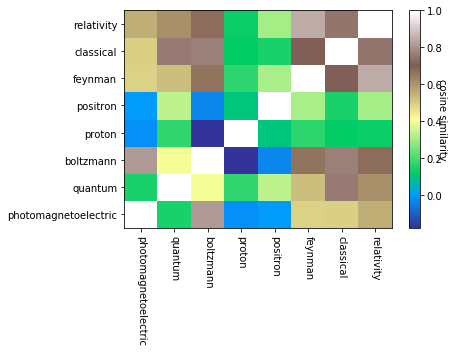

In [138]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [90]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

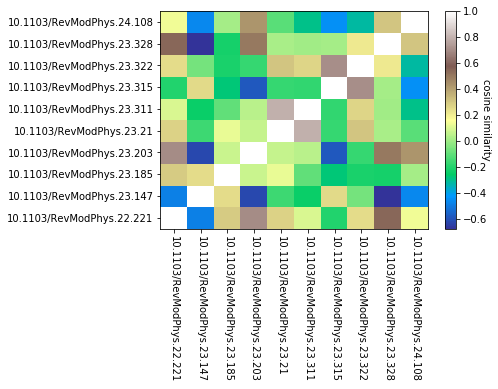

In [91]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [92]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

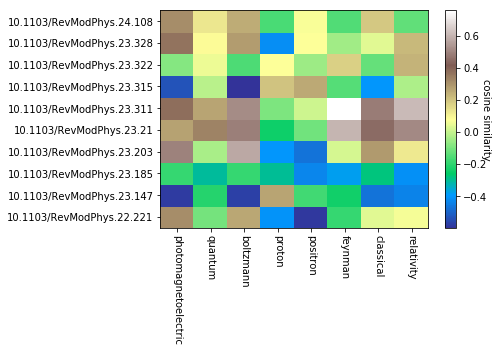

In [93]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [94]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

Each row is for one bsuiness, so the text is a combination of all reviews from one business.

In [248]:
yelp_review_bigdf = pandas.read_csv('~/review_small.csv', sep='\t')
yelp_review_bigdf = yelp_review_bigdf.dropna(axis=0, how='any')
yelp_review_bigdf = yelp_review_bigdf.drop(columns=['id','stars','date','useful','funny','cool','business_id.1','user_id','count'])
yelp_review_bigdf = yelp_review_bigdf.groupby('business_id').apply(lambda x: x.sum())
yelp_review_bigdf

,text,business_id
business_id,,
--6MefnULPED_I942VcFNA,Good quality Chinese food. Decor is nice for ...,--6MefnULPED_I942VcFNA--6MefnULPED_I942VcFNA--...
--7zmmkVg-IMGaXbuVd0SQ,"Last week, I attended an event that I'll never...",--7zmmkVg-IMGaXbuVd0SQ--7zmmkVg-IMGaXbuVd0SQ--...
--8LPVSo5i0Oo61X01sV9A,Dr.LaCognata did my knee replacement surgery a...,--8LPVSo5i0Oo61X01sV9A--8LPVSo5i0Oo61X01sV9A--...
--9QQLMTbFzLJ_oT-ON3Xw,Don't ever believe the check in time. You'll a...,--9QQLMTbFzLJ_oT-ON3Xw--9QQLMTbFzLJ_oT-ON3Xw--...
--DaPTJW3-tB1vP-PfdTEg,"Just tried this breakfast joint, didn't want t...",--DaPTJW3-tB1vP-PfdTEg--DaPTJW3-tB1vP-PfdTEg--...
--DdmeR16TRb3LsjG0ejrQ,Disclaimer: I attended the World Food Champion...,--DdmeR16TRb3LsjG0ejrQ--DdmeR16TRb3LsjG0ejrQ--...
--ab39IjZR_xUf81WyTyHg,We were Very pleased with our service we had g...,--ab39IjZR_xUf81WyTyHg--ab39IjZR_xUf81WyTyHg--...
--cgVkbWTiga3OYTkymKqA,"I was a new person in the city, and I had an a...",--cgVkbWTiga3OYTkymKqA--cgVkbWTiga3OYTkymKqA--...
--cjBEbXMI2obtaRHNSFrA,This spot is pretty to new the Pittsburgh scen...,--cjBEbXMI2obtaRHNSFrA--cjBEbXMI2obtaRHNSFrA--...


Now we define some keywords and preprossessing the text reviews.

In [249]:
review_keywords = ['food','location','ambiance','decor']

yelp_review_bigdf['tokenized_texts'] = yelp_review_bigdf['text'].apply(lambda x:nltk.word_tokenize(x))
yelp_review_bigdf['normalized_tokens'] = yelp_review_bigdf['tokenized_texts'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

yelp_review_bigdf[:5]


,text,business_id,tokenized_texts,normalized_tokens
business_id,,,,
--6MefnULPED_I942VcFNA,Good quality Chinese food. Decor is nice for ...,--6MefnULPED_I942VcFNA--6MefnULPED_I942VcFNA--...,"[Good, quality, Chinese, food, ., Decor, is, n...","[good, quality, chinese, food, decor, nice, ch..."
--7zmmkVg-IMGaXbuVd0SQ,"Last week, I attended an event that I'll never...",--7zmmkVg-IMGaXbuVd0SQ--7zmmkVg-IMGaXbuVd0SQ--...,"[Last, week, ,, I, attended, an, event, that, ...","[last, week, attended, event, never, forget, p..."
--8LPVSo5i0Oo61X01sV9A,Dr.LaCognata did my knee replacement surgery a...,--8LPVSo5i0Oo61X01sV9A--8LPVSo5i0Oo61X01sV9A--...,"[Dr.LaCognata, did, my, knee, replacement, sur...","[knee, replacement, surgery, wonderful, job, w..."
--9QQLMTbFzLJ_oT-ON3Xw,Don't ever believe the check in time. You'll a...,--9QQLMTbFzLJ_oT-ON3Xw--9QQLMTbFzLJ_oT-ON3Xw--...,"[Do, n't, ever, believe, the, check, in, time,...","[ever, believe, check, time, always, min, wait..."
--DaPTJW3-tB1vP-PfdTEg,"Just tried this breakfast joint, didn't want t...",--DaPTJW3-tB1vP-PfdTEg--DaPTJW3-tB1vP-PfdTEg--...,"[Just, tried, this, breakfast, joint, ,, did, ...","[tried, breakfast, joint, want, old, boom, way..."


In [250]:
taggedDocs_review = []
for index, row in yelp_review_bigdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords_review = [s for s in review_keywords if s in row['normalized_tokens']]
    #docKeywords_review.append(row['copyrightYear'])
    docKeywords_review.append(row['business_id']) #This lets us extract individual documnets since doi's are unique
    taggedDocs_review.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords_review))
yelp_review_bigdf['TaggedTexts'] = taggedDocs_review
yelp_review_bigdf[:10]

,text,business_id,tokenized_texts,normalized_tokens,TaggedTexts
business_id,,,,,
--6MefnULPED_I942VcFNA,Good quality Chinese food. Decor is nice for ...,--6MefnULPED_I942VcFNA--6MefnULPED_I942VcFNA--...,"[Good, quality, Chinese, food, ., Decor, is, n...","[good, quality, chinese, food, decor, nice, ch...","([good, quality, chinese, food, decor, nice, c..."
--7zmmkVg-IMGaXbuVd0SQ,"Last week, I attended an event that I'll never...",--7zmmkVg-IMGaXbuVd0SQ--7zmmkVg-IMGaXbuVd0SQ--...,"[Last, week, ,, I, attended, an, event, that, ...","[last, week, attended, event, never, forget, p...","([last, week, attended, event, never, forget, ..."
--8LPVSo5i0Oo61X01sV9A,Dr.LaCognata did my knee replacement surgery a...,--8LPVSo5i0Oo61X01sV9A--8LPVSo5i0Oo61X01sV9A--...,"[Dr.LaCognata, did, my, knee, replacement, sur...","[knee, replacement, surgery, wonderful, job, w...","([knee, replacement, surgery, wonderful, job, ..."
--9QQLMTbFzLJ_oT-ON3Xw,Don't ever believe the check in time. You'll a...,--9QQLMTbFzLJ_oT-ON3Xw--9QQLMTbFzLJ_oT-ON3Xw--...,"[Do, n't, ever, believe, the, check, in, time,...","[ever, believe, check, time, always, min, wait...","([ever, believe, check, time, always, min, wai..."
--DaPTJW3-tB1vP-PfdTEg,"Just tried this breakfast joint, didn't want t...",--DaPTJW3-tB1vP-PfdTEg--DaPTJW3-tB1vP-PfdTEg--...,"[Just, tried, this, breakfast, joint, ,, did, ...","[tried, breakfast, joint, want, old, boom, way...","([tried, breakfast, joint, want, old, boom, wa..."
--DdmeR16TRb3LsjG0ejrQ,Disclaimer: I attended the World Food Champion...,--DdmeR16TRb3LsjG0ejrQ--DdmeR16TRb3LsjG0ejrQ--...,"[Disclaimer, :, I, attended, the, World, Food,...","[disclaimer, attended, world, food, championsh...","([disclaimer, attended, world, food, champions..."
--ab39IjZR_xUf81WyTyHg,We were Very pleased with our service we had g...,--ab39IjZR_xUf81WyTyHg--ab39IjZR_xUf81WyTyHg--...,"[We, were, Very, pleased, with, our, service, ...","[pleased, service, great, service, alex, today...","([pleased, service, great, service, alex, toda..."
--cgVkbWTiga3OYTkymKqA,"I was a new person in the city, and I had an a...",--cgVkbWTiga3OYTkymKqA--cgVkbWTiga3OYTkymKqA--...,"[I, was, a, new, person, in, the, city, ,, and...","[new, person, city, accident, know, call, foun...","([new, person, city, accident, know, call, fou..."
--cjBEbXMI2obtaRHNSFrA,This spot is pretty to new the Pittsburgh scen...,--cjBEbXMI2obtaRHNSFrA--cjBEbXMI2obtaRHNSFrA--...,"[This, spot, is, pretty, to, new, the, Pittsbu...","[spot, pretty, new, pittsburgh, scene, althoug...","([spot, pretty, new, pittsburgh, scene, althou..."


Now we can train a Doc2Vec model:

In [251]:
#MYCODE
yelp_bigD2V = gensim.models.doc2vec.Doc2Vec(yelp_review_bigdf['TaggedTexts'], size = 100) #Limiting to 100 dimensions

Now let's plot some words and documents against one another with a heatmap:

In [252]:
heatmapMatrix_review = []
for tagOuter in review_keywords:
    column = []
    tagVec = yelp_bigD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in review_keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec,yelp_bigD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix_review.append(column)
heatmapMatrix_review = np.array(heatmapMatrix_review)

First of all let's see the relationship between each keyword. We can see that most of these words are highly correlated. As they are all topics of restaurant reviews, so it makes sense that there is this high similarity. 

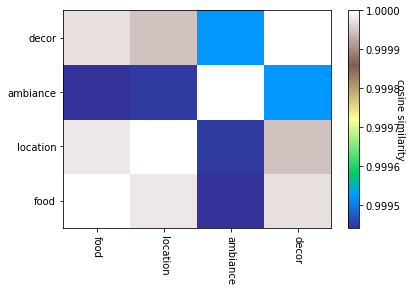

In [150]:
#mycode
fig, ax = plt.subplots()
hmap_review = ax.pcolor(heatmapMatrix_review, cmap='terrain')
cbar_review = plt.colorbar(hmap_review)

cbar_review.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix_review.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix_review.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(review_keywords, minor=False, rotation=270)
a = ax.set_yticklabels(review_keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [253]:
#MYCODE
targetDocs_review = yelp_review_bigdf['business_id']

heatmapMatrixD_review = []

for tagOuter in targetDocs_review:
    column = []
    tagVec = yelp_bigD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs_review:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, yelp_bigD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD_review.append(column)
heatmapMatrixD_review = np.array(heatmapMatrixD_review)

Now let's see the relationship between each document. We can see that most of these documents are highly correlated as well, meaning that the reviews are not that diverse. They are all talking about similar stuff. May be it is because I did not choose the document randomly. In stead, I used convience sampling.  

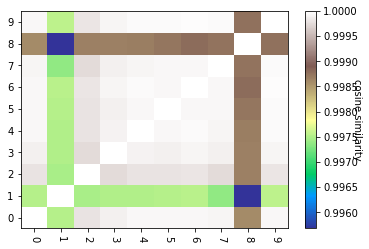

In [254]:
fig, ax = plt.subplots()
hmap_review = ax.pcolor(heatmapMatrixD_review, cmap='terrain')
cbar_review = plt.colorbar(hmap_review)

cbar_review.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD_review.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD_review.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(np.arange(10), rotation=270)
a = ax.set_yticklabels(np.arange(10))

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [255]:
#MYCODE
heatmapMatrixC_review = []

for tagOuter in targetDocs_review:
    column = []
    tagVec = yelp_bigD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in review_keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, yelp_bigD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC_review.append(column)
heatmapMatrixC_review = np.array(heatmapMatrixC_review)

We can see that the first and eighth document are not as complete as the other documents. And ambiance is the least mentioned type of topic in these reviews. 

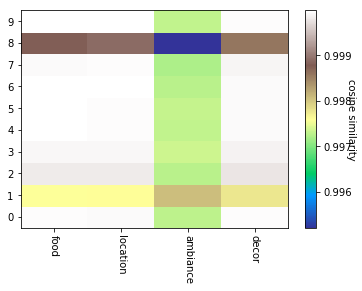

In [256]:
fig, ax = plt.subplots()
hmap_review = ax.pcolor(heatmapMatrixC_review, cmap='terrain')
cbar_review = plt.colorbar(hmap_review)

cbar_review.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC_review.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC_review.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(review_keywords, minor=False, rotation=270)
a = ax.set_yticklabels(np.arange(10), minor=False)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [177]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')


In [ ]:
#MYCODE
yelp_reviewW2V = gensim.models.word2vec.Word2Vec(yelp_review_df['normalized_sents'].sum())


First we can visualize with dimension reduction

In [163]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [164]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

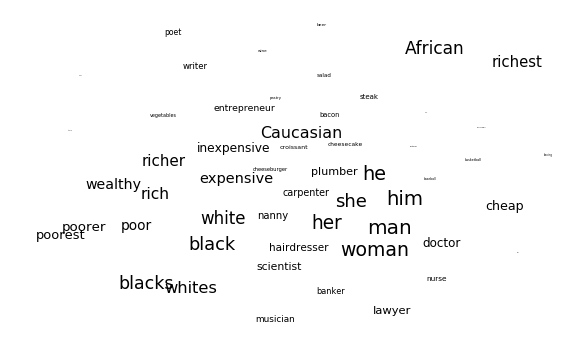

In [165]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [166]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [167]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [168]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

In [238]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    print(df)
    return df


Get the projections.

In [239]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

                 class    gender      race
doctor       -0.101023 -0.058048 -0.098297
lawyer        0.052377  0.021787  0.014264
plumber      -0.003232  0.038784 -0.082154
scientist     0.017319  0.053595 -0.107106
hairdresser  -0.027526 -0.364141 -0.160411
nanny        -0.008819 -0.220270 -0.135943
carpenter     0.017506 -0.063229 -0.102722
entrepreneur  0.177146  0.033817 -0.116234
musician      0.012577 -0.079396 -0.080416
writer        0.125964 -0.101106 -0.119433
banker        0.223426  0.066229  0.009015
poet          0.114924 -0.079829 -0.112803
nurse        -0.127380 -0.275093 -0.146441
                 class    gender      race
steak         0.127592  0.007895 -0.172440
bacon         0.100991 -0.018462 -0.158186
croissant     0.016502 -0.084794 -0.227760
cheesecake    0.091551 -0.131204 -0.223237
salad         0.038699 -0.110827 -0.157910
cheeseburger  0.026884  0.039346 -0.140119
vegetables   -0.073452 -0.077072 -0.110847
beer          0.038667  0.017974 -0.141823
wine       

Define some useful functions for plotting.

In [242]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

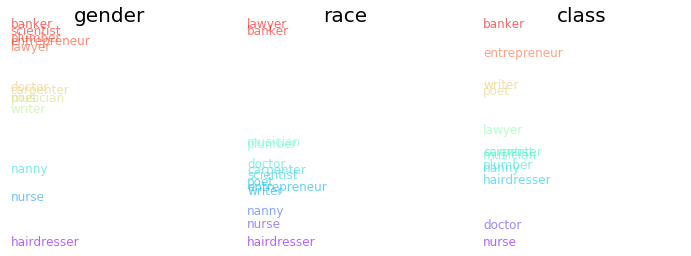

In [172]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

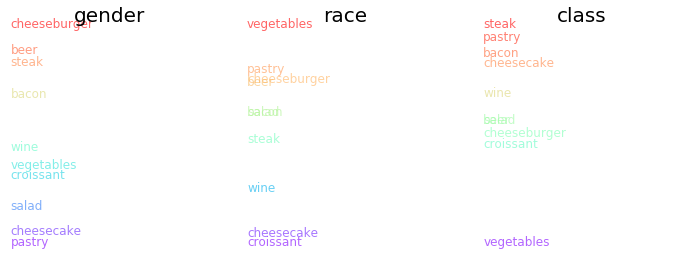

In [173]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

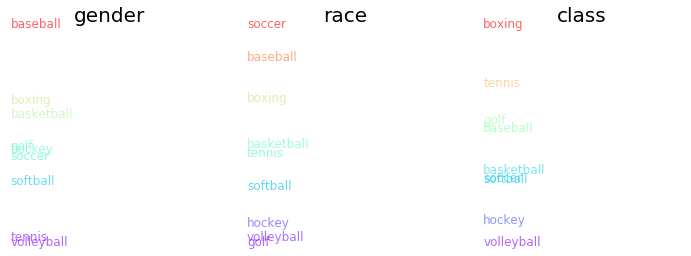

In [174]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

In [191]:
remove_words = ['he','him','she','her','his','hers','himself','herself']
new_stop_list = [word for word in lucem_illud.stop_words_basic if word not in remove_words]


In [192]:
yelp_review_df['normalized_new'] = yelp_review_df['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = new_stop_list, 
                                                                                           stemmer = None) 
                                                                            for s in x])

In [227]:
new_yelp_reviewW2V = gensim.models.word2vec.Word2Vec(yelp_review_df['normalized_new'].sum())

Let's calculate three dimensions: gender, race, and age (of the person who is being talked abouts).

In [ ]:
Gender_review = dimension(new_yelp_reviewW2V, ['man','husband','he','his'], ['woman', 'wife', 'she','hers'])
Age_review = dimension(new_yelp_reviewW2V,['son','daughter','baby'],['wife','husband','couple'])
Race_review = dimension(new_yelp_reviewW2V, ['black'], ['white'])

Here we are interested in learning how these words are lated to each dimension

In [228]:
Foods_review = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]
Cuisine_review = ['asian','indian','american','mexican','chinese','thai']
Drink_review = ['soda','wine','beer','cocktail','coffee','juice','coke']

Define a function to project words in a word list to each of the three dimensions.

In [240]:
def makeDF_review(model, word_list):
    g = []
    a = []
    r = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(yelp_reviewW2V[word].reshape(1,-1), Gender_review.reshape(1,-1))[0][0])
        a.append(sklearn.metrics.pairwise.cosine_similarity(yelp_reviewW2V[word].reshape(1,-1), Age_review.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(yelp_reviewW2V[word].reshape(1,-1), Race_review.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'age': a}, index = word_list)
    return df

Get the projections

In [244]:
Cuisinedf = makeDF_review(new_yelp_reviewW2V, Cuisine_review) 
Foodsdf = makeDF_review(new_yelp_reviewW2V, Foods_review)
Drinksdf = makeDF_review(new_yelp_reviewW2V, Drink_review)

Plot the cuisine words in each of the three dimensions. Here we can see that cuisine makes a big difference. Men and blacks are more interested in Thai food.Young children are more insterested in mexican food, which is very interesting.

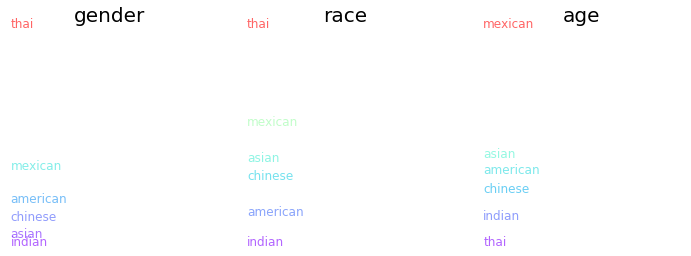

In [224]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Cuisinedf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Cuisinedf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Cuisinedf, 'age')
plt.show()

Plot the food words in each of the three dimensions. Here we can see that food type does not make a very big difference among gender, race and age. One thing that meets my expectation is that whites favor healthy food, like vegetables, salad, more than blacks. Young children prefer sweeter food, like cheesecake more than adults. 

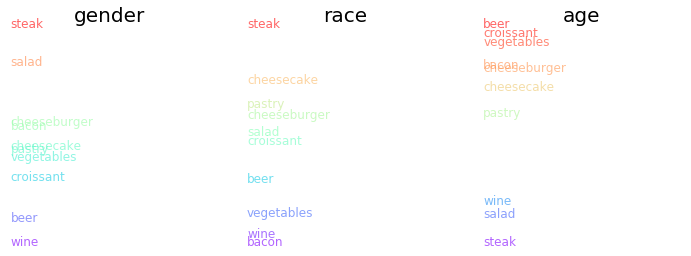

In [225]:

fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Foodsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Foodsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Foodsdf, 'age')
plt.show()

Plot the drinks words in each of the three dimensions. Here we can see that drink type is sparse among gender, race and age. One thing that surprises me is that cocktail is more close to young age! The reasons could be various. For example, since I define my dimension of younge as "son" and "daughter", they might not necessarily means children. 20-year old could also be son and daughter, and it makes more sense if cocktail is more related to them. 

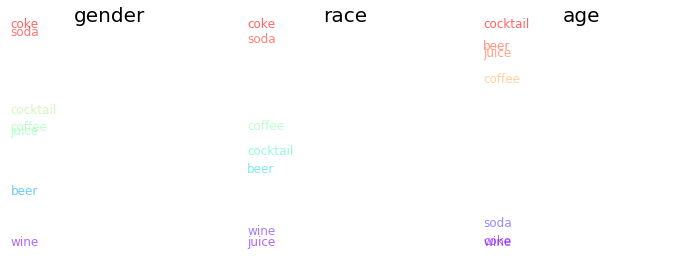

In [243]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Drinksdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Drinksdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Drinksdf, 'age')
plt.show()